# LSTM  para predecir a los pasajeros de las aerolíneas internacionales

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional 
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\Jergb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# convertimos un array de valores en una matriz de conjuntos de datos
Con esto tenemos la salida a n muestras siguientes

In [2]:
# convertir un array de valores en una matriz de conjuntos de datos
def datos_salida(data, predice_pasos=1):
    x = data.iloc[0:-predice_pasos].values
    y = data.iloc[predice_pasos::,0].values
    return numpy.array(x), numpy.array(y)

# Se define una semilla constante para controlar la estabilidad del modelo.
Con esto se garantiza que el modelo se entrene siempre con la misma secuencia de numeros aleatorios.

In [3]:
numpy.random.seed(5)

# cargamos el conjunto de datos

dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python',skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.shape

(4559, 1)

(4559, 1)

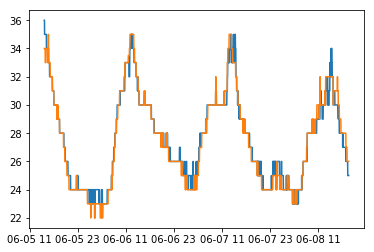

In [4]:
datos = pd.read_csv('ajustado.csv', parse_dates=True,index_col=0)
d_prueba = pd.read_csv('nodo3_periodo3.csv', parse_dates=True,index_col=0)
d_prueba = d_prueba.drop(columns=['HORA'])
data = pd.DataFrame(datos.loc[:,'TEMPERATURA'])
probar = pd.DataFrame(d_prueba.loc[:,'TEMPERATURA'])
#data = data.astype('float32')
display(data.shape,probar.shape)
plt.plot(probar)
plt.plot(data)


In [5]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
probar = scaler.fit_transform(probar)

In [6]:
# dividimos entre entranmiento y test
ld = len(data)
entrenar = pd.DataFrame(data[0:int(ld * 0.7)])
validar = pd.DataFrame(data[int(ld * 0.7)::])
probar = pd.DataFrame(probar)

In [7]:
# remodelamos X=t y Y=t+1
entrenarX, entrenarY = datos_salida(entrenar, 1)
validarX, validarY = datos_salida(validar, 1)
probarX, probarY = datos_salida(probar, 1)

In [8]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
entrenarX = numpy.reshape(entrenarX, (entrenarX.shape[0], 1, entrenarX.shape[1]))
validarX = numpy.reshape(validarX, (validarX.shape[0], 1, validarX.shape[1]))
probarX = numpy.reshape(probarX, (probarX.shape[0], 1, probarX.shape[1]))
#creamos la LSTM network

model = Sequential()
model.add(Bidirectional(LSTM(4, input_shape=(1, 1))))
model.add(Dense(1))
# evaluar la exactitud de las predicciones de un modelo a través del error de la raíz cuadrada de la media (RMSE)
# El error de entrenamiento mide qué tan bien ajusta los datos de entrenamiento tu modelo
#El error cuadrático medio (MSE) puede ser difícil de interpretar; es por esto que generalmente observamos el error 
# de la raíz cuadrada de la media (RMSE) en su lugar. Una propiedad interesante del RMSE es que se puede interpretar 
# en la misma escala que los objetivos originales
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(entrenarX, entrenarY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 11s - loss: 0.0126
Epoch 2/10
 - 7s - loss: 2.3171e-04
Epoch 3/10
 - 9s - loss: 2.4205e-04
Epoch 4/10
 - 7s - loss: 2.4240e-04
Epoch 5/10
 - 8s - loss: 2.4137e-04
Epoch 6/10
 - 8s - loss: 2.3694e-04
Epoch 7/10
 - 7s - loss: 2.4040e-04
Epoch 8/10
 - 9s - loss: 2.4322e-04
Epoch 9/10
 - 8s - loss: 2.4260e-04
Epoch 10/10
 - 8s - loss: 2.3631e-04


In [9]:
# hacemos las predicciones
entrenar_predic = model.predict(entrenarX)
validar_predic = model.predict(validarX)
probar_predic = model.predict(probarX)

In [10]:
# invertimos las predicciones
entrenar_predic = scaler.inverse_transform(entrenar_predic)
entrenarY = scaler.inverse_transform([entrenarY])
validar_predic = scaler.inverse_transform(validar_predic)
validarY = scaler.inverse_transform([validarY])
probar_predic = scaler.inverse_transform(probar_predic)
probarY = scaler.inverse_transform([probarY])

In [11]:
# calculamos el error rms
r_entrenamiento = math.sqrt(mean_squared_error(entrenarY[0], entrenar_predic[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (r_entrenamiento))
r_validacion = math.sqrt(mean_squared_error(validarY[0], validar_predic[:,0]))
print('Resultado de la validación: %.2f RMSE' % (r_validacion))
r_prueba = math.sqrt(mean_squared_error(probarY[0], probar_predic[:,0]))
print('Resultado de la prueba: %.2f RMSE' % (r_prueba))

Resultado del entrenamiento: 0.19 RMSE
Resultado de la validación: 0.20 RMSE
Resultado de la prueba: 0.25 RMSE


In [12]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[1:len(entrenar_predic)+1, :] = entrenar_predic

In [13]:
# predicciones del test de cambio para plotear
vPredictPlot = numpy.empty_like(data)
vPredictPlot[:, :] = numpy.nan
vPredictPlot[len(entrenar_predic)+2:len(data), :] = validar_predic

In [14]:
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(d_prueba)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[1:len(d_prueba)+1, :] = probar_predic

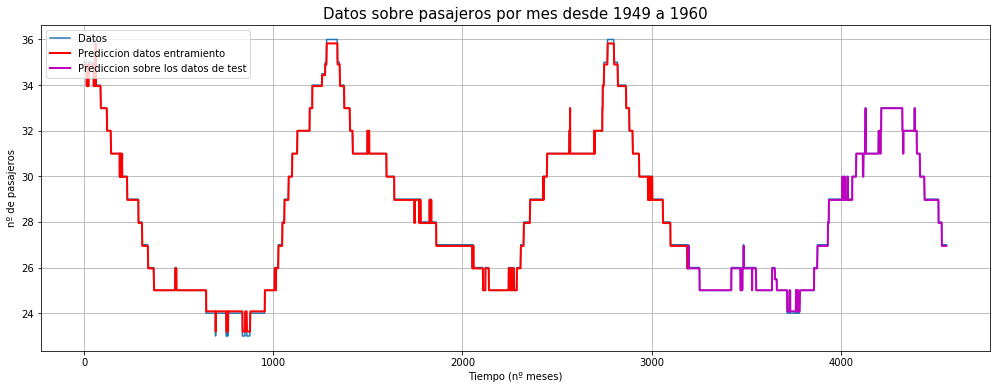

In [15]:
plt.figure(figsize=(17,6))
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(vPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

Resultado de la prueba: 6.02 RMSE


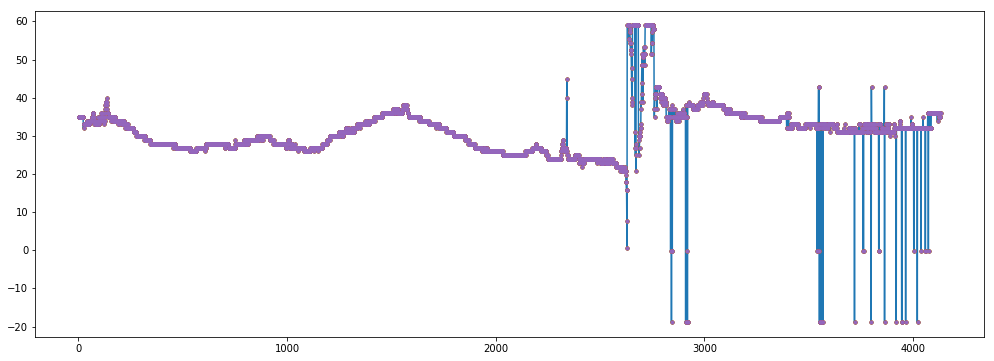

In [16]:
d_prueba = pd.read_csv('nodo2_periodo2.csv', parse_dates=True,index_col=0)
d_prueba = d_prueba.drop(columns=['HORA'])
probar = pd.DataFrame(d_prueba.iloc[:,-1])
plt.figure(figsize=(17,6))
# normalizamos el conjunto de datos

scaler = MinMaxScaler(feature_range=(0, 1))
probar = pd.DataFrame(scaler.fit_transform(probar))

probarX, probarY = datos_salida(probar, 1)

probarX = numpy.reshape(probarX, (probarX.shape[0], 1, probarX.shape[1]))
probar_predic = model.predict(probarX)


probar_predic = scaler.inverse_transform(probar_predic)
probarY = scaler.inverse_transform([probarY])

r_prueba = math.sqrt(mean_squared_error(probarY[0], probar_predic[:,0]))
print('Resultado de la prueba: %.2f RMSE' % (r_prueba))
testPredictPlot = numpy.empty_like(d_prueba)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[1:len(probar)+1, :] = probar_predic
plt.plot(probar_predic)
plt.plot(testPredictPlot,'.')

In [17]:
probar.shape

(4133, 1)

In [18]:
probar = pd.DataFrame(scaler.fit_transform([[30],[30],[30],[31],[30],[74],[30]]))

probarX, probarY = datos_salida(probar, 1)

probarX = numpy.reshape(probarX, (probarX.shape[0], 1, probarX.shape[1]))
probar_predic = model.predict(probarX)
probar_predic = scaler.inverse_transform(probar_predic)
display(probar_predic,probarX,probar)

array([[30.657501],
       [30.657501],
       [30.657501],
       [31.527502],
       [30.657501],
       [73.41219 ]], dtype=float32)

array([[[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.02272727]],

       [[0.        ]],

       [[1.        ]]])

,0
0,0.000000
1,0.000000
2,0.000000
3,0.022727
4,0.000000
5,1.000000
6,0.000000


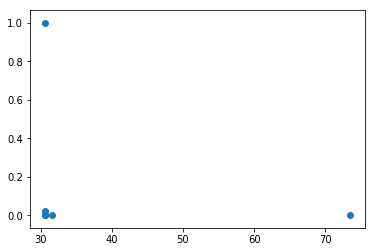

In [19]:
plt.scatter(probar_predic,probarY)

In [20]:
probarX[0:5]

array([[[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.02272727]],

       [[0.        ]]])

In [21]:
probarY[0:5]

array([0.        , 0.        , 0.02272727, 0.        , 1.        ])

Resultado del entrenamiento: 23.34 RMSE
Resultado del test: 47.56 RMSE

- bidireccional:
Resultado del entrenamiento: 22.85 RMSE
Resultado del test: 48.85 RMSE
